In [105]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook


### HGNC Mapper

In [2]:
hgnc = pd.read_csv('../../data/hgnc_alias_list.txt', sep='\t')
hgnc.head()

hgnc = hgnc[hgnc['Approved symbol'].apply(lambda x: 'withdrawn' not in x)]

# get the original keys
hgnc_original_keys = hgnc['Approved symbol'].unique()

# drop a lot of columns for efficiency
hgnc = hgnc[list(hgnc.columns)[0:6]].drop('Status', axis=1)

# filter out Nan synonyms (not helpful)
hgnc_syn_list = hgnc[~ hgnc.Synonyms.isna()]
hgnc_prev_symb_list = hgnc[~ hgnc['Previous symbols'].isna()]

print(hgnc_syn_list.shape)
print(hgnc_syn_list.columns)
display(hgnc_syn_list.head())

print(hgnc_prev_symb_list.shape)
print(hgnc_prev_symb_list.columns)
display(hgnc_prev_symb_list.head())

#convert the synonyms column to a list
# convert these lists to pd.Series
# merge with original dataframe
#drop old synonyms column 
# melt the new columns into rows


current_syn_list = hgnc_syn_list.Synonyms.apply(lambda x: x.split(',')) \
    .apply(pd.Series) \
    .merge(hgnc, left_index = True, right_index = True) \
    .drop(["Synonyms"], axis = 1) \
    .melt(id_vars = ['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols'], value_name = "synonym") 

current_syn_list = current_syn_list[~ current_syn_list.synonym.isna()]
current_syn_list.synonym = current_syn_list.synonym.apply(lambda x: x.replace(' ',''))

prev_symb_list = hgnc_prev_symb_list['Previous symbols'].apply(lambda x: x.split(',')) \
    .apply(pd.Series) \
    .merge(hgnc, left_index = True, right_index = True) \
    .drop(['Previous symbols'], axis = 1) \
    .melt(id_vars = ['HGNC ID', 'Approved symbol', 'Approved name', 'Synonyms'], value_name = "synonym") 

prev_symb_list = prev_symb_list[~ prev_symb_list.synonym.isna()]
prev_symb_list.synonym = prev_symb_list.synonym.apply(lambda x: x.replace(' ',''))


hgnc_mapper = dict(zip(current_syn_list['synonym'], current_syn_list['Approved symbol']))
# add in HGNC ID mapper
hgnc_mapper.update(dict(zip(current_syn_list['HGNC ID'], current_syn_list['Approved symbol'])))
hgnc_mapper_previous = dict(zip(prev_symb_list['synonym'], prev_symb_list['Approved symbol']))

trouble_list = list(filter(lambda x: hgnc_mapper[x] != hgnc_mapper_previous[x], set(hgnc_mapper.keys())&set(hgnc_mapper_previous.keys())))

louvain_tier1 = pd.read_csv('../../results/louvain_clusters.txt', sep='\t')
for n in louvain_tier1.names:
    if (n in trouble_list):
        print(n)

hand_coded = {'RAGE':'MOK', 'SGK2':'SGK2', 'SGK196':'SGK196'}

hgnc_mapper_previous.update(hgnc_mapper) #overwrite the previous symbol conflicts

hgnc_mapper = hgnc_mapper_previous
hgnc_mapper.update({x:x for x in hgnc_original_keys}) #keep the identify maps
hgnc_mapper.update(hand_coded) # overwrite the trouble list

(21435, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


,HGNC ID,Approved symbol,Approved name,Previous symbols,Synonyms
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569
2,HGNC:24086,A1CF,APOBEC1 complementation factor,NaN,"ACF, ASP, ACF64, ACF65, APOBEC1CF"
4,HGNC:7,A2M,alpha-2-macroglobulin,NaN,"FWP007, S863-7, CPAMD5"
6,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,"FLJ25179, p170"
12,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,"IGBS3S, IGB3S"


(11702, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


,HGNC ID,Approved symbol,Approved name,Previous symbols,Synonyms
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569
6,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,"FLJ25179, p170"
9,HGNC:8,A2MP1,alpha-2-macroglobulin pseudogene 1,A2MP,NaN
12,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,"IGBS3S, IGB3S"
13,HGNC:18149,A4GALT,"alpha 1,4-galactosyltransferase (P blood group)",P1,"A14GALT, Gb3S, P(k)"


RAGE


### Import Louvain Clusters

In [3]:
louvain_tier1 = pd.read_csv('../../results/louvain_clusters.txt', sep='\t')
louvain_tier2 = pd.read_csv('../../results/louvain_small_clusters.txt', sep='\t')

louvain_tier1.names = louvain_tier1.names.apply(lambda x: hgnc_mapper[x])
louvain_tier2.names = louvain_tier2.names.apply(lambda x: hgnc_mapper[x])

louv = louvain_tier1.merge(louvain_tier2, on='names', suffixes=['_super','_sub'])
louv.head()

,names,cluster_super,cluster_sub
0,PAK1,5,3
1,ERBB2,5,18
2,MST1R,5,18
3,YES1,5,18
4,TYRO3,5,18


### Import Drug Targeting

In [4]:
drug_data = pd.read_excel('../../data/Klaeger_Science_2017 Supplementary Table 6 Selectivities.xlsx', sheet_name='CATDS target')

# filter to only hgnc keys
drug_data = drug_data[drug_data.Target.isin(hgnc_mapper.keys())]

double_drug_targets = drug_data[drug_data['Target'].apply(lambda x: ';' in x)]
#double_drug_targets.shape

first_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[0])
second_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[1])

repaired_double_targets = double_drug_targets.drop('Target', axis=1).assign(**{'Target':first_genes})
repaired_double_targets = repaired_double_targets.append(double_drug_targets.drop('Target', axis=1).assign(**{'Target':second_genes})) 
#repaired_double_targets = repaired_double_targets[cols_to_keep]

drug_data = drug_data.drop(double_drug_targets.index).append(repaired_double_targets)

# convert to hgnc
drug_data.Target = drug_data.Target.apply(lambda x: hgnc_mapper[x])

# sort columns
drug_data = drug_data[['Target', 'Drug', 'At', 'CATDS']]
drug_data = drug_data[drug_data.Target.isin(set(louv['names']))]
drug_data.head()


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6701: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Target,Drug,At,CATDS
0,AURKA,MK-5108,0.120921,0.657165
1,CHEK1,PF-477736,0.243725,0.733257
2,FLT3,Dovitinib,0.265240,0.860803
4,MET,Capmatinib,0.337514,1.000000
5,MAPKAPK2,VX-702,0.342705,0.743594


In [5]:
kin_drug_sets = drug_data.groupby('Target').agg({'Drug':list})
kin_drug_sets = kin_drug_sets.reindex(louv.set_index('names').index)
louv = louv.merge(kin_drug_sets, on='names')
#louv.head()
#kin_drug_sets

### Import Understudied

In [6]:
understudied = pd.read_csv('../../data/dark_kinases.csv')
understudied.head()
#louv['']

,hgnc_id,symbol,ensembl_gene_id,class,name,uniprot_ids,kinase_com_name
0,HGNC:19038,ADCK1,ENSG00000063761,Dark,aarF domain containing kinase 1,Q86TW2,ADCK1
1,HGNC:19039,ADCK2,ENSG00000133597,Dark,aarF domain containing kinase 2,Q7Z695,ADCK2
2,HGNC:21738,ADCK5,ENSG00000173137,Dark,aarF domain containing kinase 5,Q3MIX3,ADCK5
3,HGNC:20565,ALPK2,ENSG00000198796,Dark,alpha kinase 2,Q86TB3,AlphaK2
4,HGNC:17574,ALPK3,ENSG00000136383,Dark,alpha kinase 3,Q96L96,AlphaK1


In [7]:
louv['understudied'] = louv['names'].isin(understudied['symbol'])
louv.head()

,names,cluster_super,cluster_sub,Drug,understudied
0,PAK1,5,3,NaN,False
1,ERBB2,5,18,NaN,False
2,MST1R,5,18,"[Golvatinib, Crizotinib, Foretinib, MK-2461, O...",False
3,YES1,5,18,"[TG-100572, Dasatinib, TAK-901, Ibrutinib, Dan...",False
4,TYRO3,5,18,NaN,False


In [8]:
from copy import copy
import itertools as it
subcluster_data = copy(louv.groupby('cluster_sub').agg({'cluster_super':np.mean,'names':len, 'understudied':lambda x: int(sum(x)), 'Drug':lambda x: list(filter(lambda y: y is not np.nan, list(x)))}))
subcluster_data.Drug = subcluster_data.Drug.apply(lambda x: list(it.chain.from_iterable(x)))
subcluster_data.head()

,cluster_super,names,understudied,Drug
cluster_sub,,,,
1,4,2,2,"[PF-3758309, Lestaurtinib, OTS-167, Sunitinib,..."
2,7,30,4,"[GDC-0994, Ulixertinib, PHA-793887, PF-477736,..."
3,5,8,2,"[Dasatinib, Ponatinib, Gilteritinib, Rebastini..."
4,2,41,1,"[Dasatinib, Ponatinib, Bosutinib, BI-847325, F..."
5,5,8,0,"[Sotrastaurin, Ruboxistaurin, UCN-01, Decernot..."


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
tfidf = TfidfVectorizer(lowercase=False, tokenizer=lambda x: x.split(','))
output = tfidf.fit_transform(raw_documents=subcluster_data['Drug'].apply(lambda x: ','.join(x)))
output

<36x218 sparse matrix of type '<class 'numpy.float64'>'
	with 1533 stored elements in Compressed Sparse Row format>

In [11]:
drug_tfidf = pd.DataFrame(output.toarray(), index=subcluster_data.index, columns=tfidf.get_feature_names())
drug_tfidf.drop('', axis=1, inplace=True)
drug_tfidf.head()

,AC-480,ACTB-1003,AEE-788,AEW-541,AMG-208,AMG-900,ARRY-380,ASP-3026,AT-13148,AT-7519,...,Vandetanib,Varlitinib,Vatalanib,Vemurafenib,Volasertib,X-396,XL-019,XL-228,XL-413,Y-39983
cluster_sub,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.197886,0.0,0.000000
2,0.0,0.120005,0.000000,0.109427,0.0,0.174847,0.0,0.028091,0.000000,0.042112,...,0.0,0.0,0.0,0.084223,0.0,0.0,0.031159,0.076568,0.0,0.032330
3,0.0,0.000000,0.153086,0.000000,0.0,0.159352,0.0,0.256012,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.116304,0.0,0.000000
4,0.0,0.048640,0.000000,0.088705,0.0,0.042521,0.0,0.068314,0.051206,0.102412,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.062069,0.0,0.157246
5,0.0,0.000000,0.000000,0.000000,0.0,0.140278,0.0,0.056342,0.084464,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.124991,0.153573,0.0,0.194533


In [12]:
drug_score = drug_tfidf.sum(axis=1) 
drug_score

cluster_sub
1      3.926111
2      8.197833
3      5.449550
4      8.339897
5      7.186975
6      9.565995
7      5.264555
8      5.348649
9      9.986641
10     6.071755
11     8.442926
12     9.431016
13     7.532303
14     0.000000
15     0.000000
16     4.700926
17     5.899515
18    10.191481
19     1.000000
20     4.939538
21     4.059190
22     4.019307
23     2.910020
24     7.009435
25     5.228162
26     0.000000
27     4.306810
28     0.000000
29     2.496789
30     1.879738
31     1.999165
32     0.000000
33     7.309061
34     0.000000
35     5.396099
36     2.367330
dtype: float64

In [13]:
subcluster_data['drug_score'] = drug_score
subcluster_data.head()

,cluster_super,names,understudied,Drug,drug_score
cluster_sub,,,,,
1,4,2,2,"[PF-3758309, Lestaurtinib, OTS-167, Sunitinib,...",3.926111
2,7,30,4,"[GDC-0994, Ulixertinib, PHA-793887, PF-477736,...",8.197833
3,5,8,2,"[Dasatinib, Ponatinib, Gilteritinib, Rebastini...",5.449550
4,2,41,1,"[Dasatinib, Ponatinib, Bosutinib, BI-847325, F...",8.339897
5,5,8,0,"[Sotrastaurin, Ruboxistaurin, UCN-01, Decernot...",7.186975


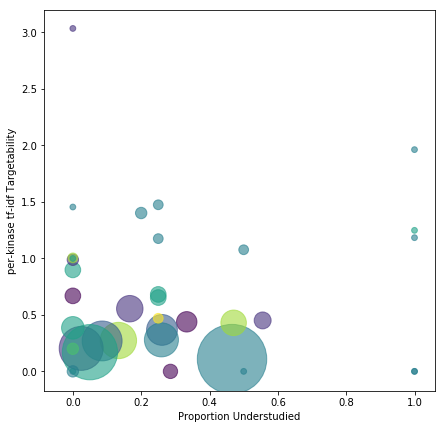

In [14]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
plt.scatter(x=subcluster_data['understudied']/subcluster_data['names'], y=subcluster_data['drug_score']/subcluster_data['names'], s=subcluster_data['names'].apply(lambda x: (np.log(x)+1)*x*10), c=subcluster_data['cluster_super'], alpha=.6)
plt.xlabel('Proportion Understudied')
plt.ylabel('per-kinase tf-idf Targetability')
#ax.set_yscale("log", basey=2)#, nonposy='clip')
#plt.ylim([-2,4])
plt.show()

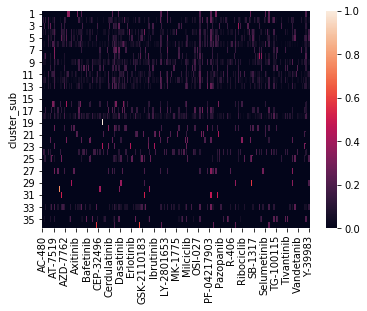

In [15]:
fig, ax = plt.subplots()
sns.heatmap(drug_tfidf)

In [16]:
drug_tfidf.dropna(axis=1)

,AC-480,ACTB-1003,AEE-788,AEW-541,AMG-208,AMG-900,ARRY-380,ASP-3026,AT-13148,AT-7519,...,Vandetanib,Varlitinib,Vatalanib,Vemurafenib,Volasertib,X-396,XL-019,XL-228,XL-413,Y-39983
cluster_sub,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.197886,0.000000,0.000000
2,0.000000,0.120005,0.000000,0.109427,0.000000,0.174847,0.000000,0.028091,0.000000,0.042112,...,0.000000,0.000000,0.000000,0.084223,0.000000,0.000000,0.031159,0.076568,0.000000,0.032330
3,0.000000,0.000000,0.153086,0.000000,0.000000,0.159352,0.000000,0.256012,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.116304,0.000000,0.000000
4,0.000000,0.048640,0.000000,0.088705,0.000000,0.042521,0.000000,0.068314,0.051206,0.102412,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062069,0.000000,0.157246
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.140278,0.000000,0.056342,0.084464,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.124991,0.153573,0.000000,0.194533
6,0.000000,0.018016,0.045391,0.000000,0.000000,0.110247,0.000000,0.050606,0.000000,0.189663,...,0.020063,0.000000,0.000000,0.000000,0.021361,0.000000,0.056133,0.091959,0.022949,0.058243
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.197010,0.000000,0.000000,0.000000,0.119402,0.000000,0.000000
8,0.000000,0.000000,0.089824,0.195055,0.000000,0.000000,0.000000,0.075108,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.204726,0.000000,0.000000
9,0.000000,0.049904,0.041911,0.045505,0.000000,0.000000,0.000000,0.070089,0.000000,0.000000,...,0.000000,0.063568,0.000000,0.052536,0.059169,0.000000,0.116615,0.127362,0.000000,0.040333


In [17]:
idf = drug_tfidf[drug_tfidf>0].min(axis=0)
idf

AC-480         0.022198
ACTB-1003      0.018016
AEE-788        0.037652
AEW-541        0.045505
AMG-208        0.022198
AMG-900        0.042521
ARRY-380       0.022198
ASP-3026       0.015696
AT-13148       0.051206
AT-7519        0.023530
AT-9283        0.073304
AV-412         0.020063
AZD-1208       0.019900
AZD-1480       0.022351
AZD-2014       0.761083
AZD-4547       0.017178
AZD-5363       0.011172
AZD-5438       0.015100
AZD-7762       0.062966
AZD-8330       0.031011
Abemaciclib    0.026157
Afatinib       0.015973
Alectinib      0.031946
Alisertib      0.051018
Alvocidib      0.019539
Apatinib       0.018270
Apitolisib     0.017178
Axitinib       0.023530
BGT-226        0.023530
BI-2536        0.013676
                 ...   
TAK-733        0.123815
TAK-901        0.031483
TG-100115      0.018270
TG-100572      0.014033
TG-100801      0.018966
Talmapimod     0.069384
Tandutinib     0.031011
Tanzisertib    0.018016
Telatinib      0.022198
Tepotinib      0.022198
Tesevatinib    0

In [18]:
drug_tfidf.loc[1:2]

,AC-480,ACTB-1003,AEE-788,AEW-541,AMG-208,AMG-900,ARRY-380,ASP-3026,AT-13148,AT-7519,...,Vandetanib,Varlitinib,Vatalanib,Vemurafenib,Volasertib,X-396,XL-019,XL-228,XL-413,Y-39983
cluster_sub,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.197886,0.0,0.00000
2,0.0,0.120005,0.0,0.109427,0.0,0.174847,0.0,0.028091,0.0,0.042112,...,0.0,0.0,0.0,0.084223,0.0,0.0,0.031159,0.076568,0.0,0.03233


In [19]:
subcluster_data['cluster_super'].index == drug_tfidf.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [20]:
subcluster_data['cluster_super'].loc[1]

4

In [21]:
from umap import UMAP

In [22]:
from sklearn.manifold import TSNE

In [23]:
red = UMAP()
out = red.fit_transform(drug_tfidf)

In [24]:
blue = TSNE()
out = blue.fit_transform(drug_tfidf)

In [25]:
from sklearn.decomposition import PCA
green = PCA(n_components=2)
out = green.fit_transform(drug_tfidf)
display(green.explained_variance_ratio_)

array([0.14846649, 0.10770413])

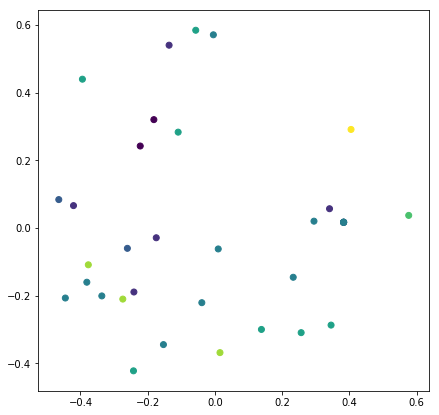

In [26]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
plt.scatter(out[:,0], out[:,1], c=subcluster_data['cluster_super'])

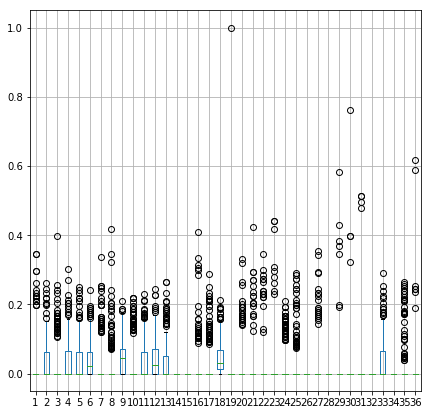

In [27]:
fig, ax = plt.subplots(figsize=(7,7), ncols=1, nrows=1)
pd.plotting.boxplot(drug_tfidf.transpose())
plt.show()

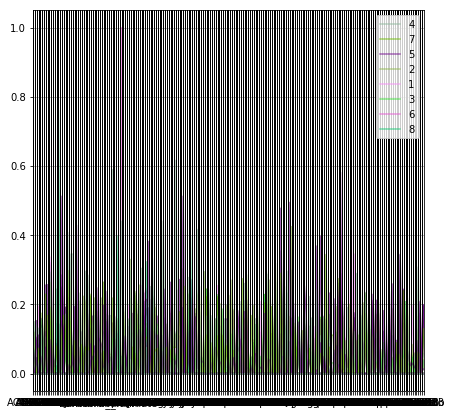

In [28]:
fig, ax = plt.subplots(figsize=(7,7), ncols=1, nrows=1)
pd.plotting.parallel_coordinates(pd.concat([drug_tfidf,subcluster_data['cluster_super']],axis=1), class_column='cluster_super', alpha=.6)
plt.show()

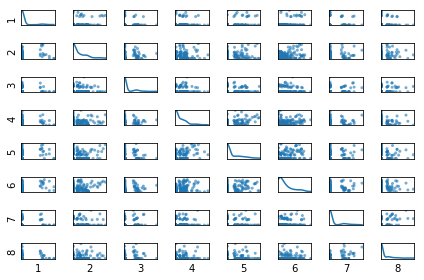

In [29]:
axes = pd.plotting.scatter_matrix(drug_tfidf.loc[1:8].transpose(), alpha=.6, diagonal='kde')
for row in axes:
    for ax in row:
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
plt.tight_layout()
plt.show()

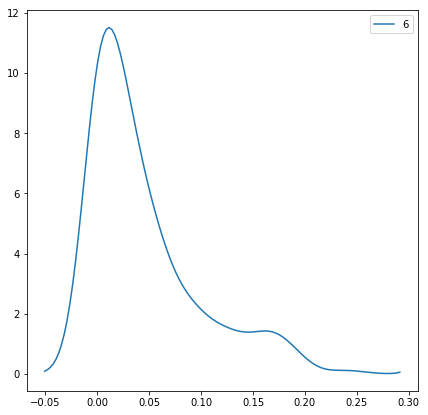

In [30]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
sns.kdeplot(data=drug_tfidf.loc[6])
plt.autoscale()
plt.show()

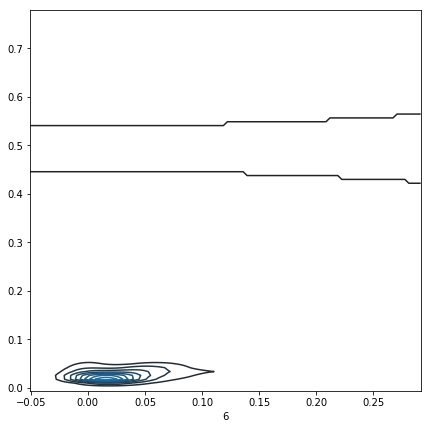

In [31]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
sns.kdeplot(data=drug_tfidf.loc[6], data2=idf)
plt.autoscale()
plt.show()

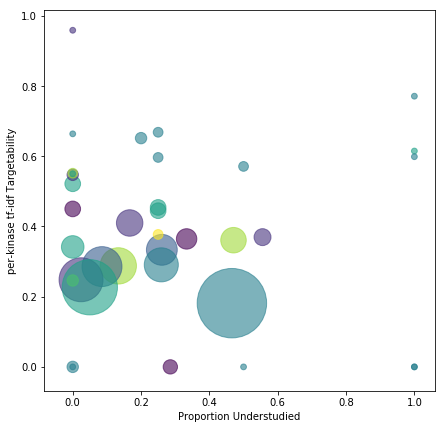

In [32]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
plt.scatter(x=subcluster_data['understudied']/subcluster_data['names'], y=np.sqrt(subcluster_data['drug_score']/subcluster_data['names']/3.3), s=subcluster_data['names'].apply(lambda x: (np.log(x)+1)*x*10), c=subcluster_data['cluster_super'], alpha=.6)
plt.xlabel('Proportion Understudied')
plt.ylabel('per-kinase tf-idf Targetability')
#ax.set_yscale("log", basey=2)#, nonposy='clip')
#plt.ylim([-2,4])
#plt.yticks([0,.25,.5,1,2])
#plt.xscale('symlog')
plt.show()

In [33]:
from matplotlib.collections import LineCollection
from scipy.spatial.distance import pdist, squareform
import matplotlib.cm as cm

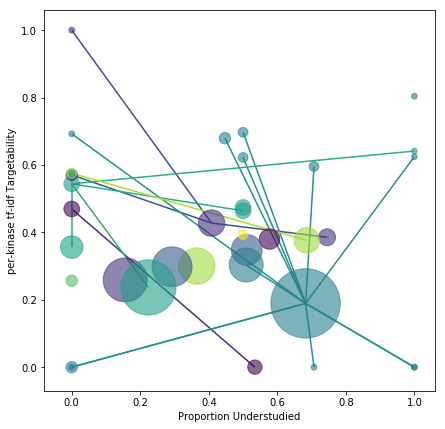

In [34]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))

under_prop = copy(subcluster_data['understudied']/subcluster_data['names'])
tfidf_clust = copy(subcluster_data['drug_score']/subcluster_data['names'])

## standardize
#under_prop = (under_prop - np.mean(under_prop))/np.std(under_prop)
#tfidf_clust = (tfidf_clust - np.mean(tfidf_clust))/np.std(tfidf_clust)

## normalize
#under_prop = (under_prop - np.min(under_prop))/(np.max(under_prop)- np.min(under_prop))
tfidf_clust = (tfidf_clust - np.min(tfidf_clust))/(np.max(tfidf_clust)- np.min(tfidf_clust))

## variance stabilize
under_prop = np.sqrt(under_prop)
tfidf_clust = np.sqrt(tfidf_clust)


plt.scatter(x=under_prop, y=tfidf_clust, s=subcluster_data['names'].apply(lambda x: (np.log(x)+1)*x*10), c=subcluster_data['cluster_super'], alpha=.6, zorder=1)
plt.xlabel('Proportion Understudied')
plt.ylabel('per-kinase tf-idf Targetability')
#ax.set_yscale("log", basey=2)#, nonposy='clip')
#plt.ylim([-2,4])
#plt.yticks([0,.25,.5,1])

for sup_ in set(subcluster_data.cluster_super.unique()):
    points_of_interest = list(zip(under_prop[subcluster_data.cluster_super == sup_], tfidf_clust[subcluster_data.cluster_super == sup_]))
    num_pres = len(points_of_interest)
    connect_to = min(1, num_pres-1)

    dist = squareform(pdist(points_of_interest, 'euclidean'))
    neighbors = np.sort(np.argsort(dist, axis=1)[:, 0:])

    points_added = set()
    coordinates = np.zeros((num_pres, connect_to, 2, 2))
    for i in range(0, num_pres):
        for j in range(0, connect_to):
            next_add = j
            if(points_of_interest[neighbors[i, next_add]][0]) in points_added:
                next_add += 1
                
            coordinates[i, j, :, 0] = np.array([points_of_interest[i][0], points_of_interest[neighbors[i, next_add]][0]])
            coordinates[i, j, :, 1] = np.array([points_of_interest[i][1], points_of_interest[neighbors[i, next_add]][1]])
            
            points_added = points_added | set([points_of_interest[neighbors[i, j]][0], points_of_interest[neighbors[i, j]][1]])
            

    # create line artists
    lines = LineCollection(coordinates.reshape((num_pres*connect_to, 2, 2)), color=cm.viridis(sup_/8.0), zorder=-1)

    ax.add_collection(lines)

#plt.yscale('logit')
#plt.xscale('logit')

#plt.autoscale()
#plt.xlim([-1,2])
#plt.ylim([-1,2])
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

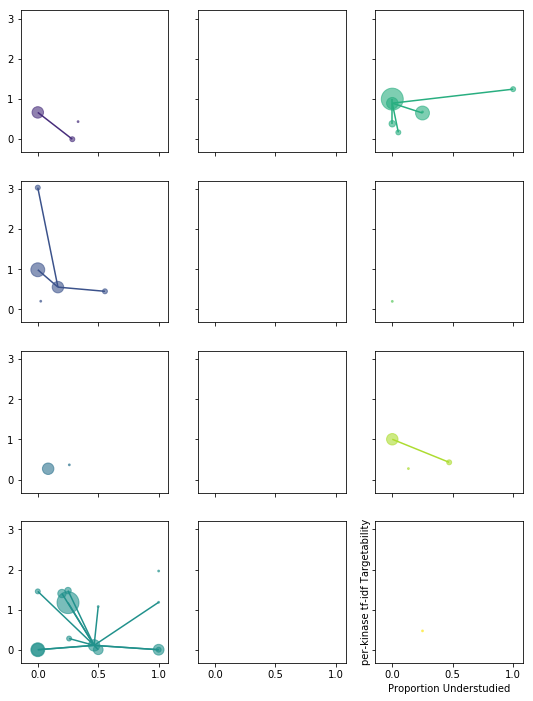

In [35]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(9,12), sharex=True, sharey=True)
#fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))

under_prop = copy(subcluster_data['understudied']/subcluster_data['names'])
tfidf_clust = copy(subcluster_data['drug_score']/subcluster_data['names'])

## standardize
#under_prop = (under_prop - np.mean(under_prop))/np.std(under_prop)
#tfidf_clust = (tfidf_clust - np.mean(tfidf_clust))/np.std(tfidf_clust)

## normalize
#under_prop = (under_prop - np.min(under_prop))/(np.max(under_prop)- np.min(under_prop))
#tfidf_clust = (tfidf_clust - np.min(tfidf_clust))/(np.max(tfidf_clust)- np.min(tfidf_clust))

## variance stabilize
#under_prop = np.sqrt(under_prop)
#tfidf_clust = np.sqrt(tfidf_clust)

for sup_, ax in zip(range(1,9), list(axes[:,0])+list(axes[:,2])):
    ax.scatter(x=under_prop[subcluster_data.cluster_super == sup_], y=tfidf_clust[subcluster_data.cluster_super == sup_], s=subcluster_data['names'].apply(lambda x: (np.log(x)+1)*x), c=cm.viridis(sup_/8.0), alpha=.6, zorder=1)
    plt.xlabel('Proportion Understudied')
    plt.ylabel('per-kinase tf-idf Targetability')
    #ax.set_yscale("log", basey=2)#, nonposy='clip')
    #plt.ylim([-2,4])
    #plt.yticks([0,.25,.5,1])


    points_of_interest = list(zip(under_prop[subcluster_data.cluster_super == sup_], tfidf_clust[subcluster_data.cluster_super == sup_]))
    num_pres = len(points_of_interest)
    connect_to = min(1, num_pres-1)

    dist = squareform(pdist(points_of_interest, 'euclidean'))
    neighbors = np.sort(np.argsort(dist, axis=1)[:, 0:])

    points_added = set()
    coordinates = np.zeros((num_pres, connect_to, 2, 2))
    for i in range(0, num_pres):
        for j in range(0, connect_to):
            next_add = j
            while(points_of_interest[neighbors[i, next_add]][0]) in points_added:
                next_add += 1

            coordinates[i, j, :, 0] = np.array([points_of_interest[i][0], points_of_interest[neighbors[i, next_add]][0]])
            coordinates[i, j, :, 1] = np.array([points_of_interest[i][1], points_of_interest[neighbors[i, next_add]][1]])

            points_added = points_added | set([points_of_interest[neighbors[i, j]][0], points_of_interest[neighbors[i, j]][1]])


    # create line artists
    lines = LineCollection(coordinates.reshape((num_pres*connect_to, 2, 2)), color=cm.viridis(sup_/8.0), zorder=-1)

    ax.add_collection(lines)

    #plt.yscale('logit')
    #plt.xscale('logit')

    #plt.autoscale()
    #plt.xlim([-1,2])
    #plt.ylim([-1,2])
    
plt.show()

### New plots

In [36]:
louv.head()

,names,cluster_super,cluster_sub,Drug,understudied
0,PAK1,5,3,NaN,False
1,ERBB2,5,18,NaN,False
2,MST1R,5,18,"[Golvatinib, Crizotinib, Foretinib, MK-2461, O...",False
3,YES1,5,18,"[TG-100572, Dasatinib, TAK-901, Ibrutinib, Dan...",False
4,TYRO3,5,18,NaN,False


In [37]:
#drug_pivot = 
from collections import Counter
from collections import defaultdict
drug_counter = Counter([])
drug_super_hits = defaultdict(Counter)


for i, row in louv.iterrows():
    drug_list = row.Drug
    if drug_list is not np.nan:
        # update the superclusters seen
        # update the drug counts for each drug
        for d in set(drug_list):
            drug_super_hits[d].update([row.cluster_super])
            drug_counter.update([d])

In [38]:
drug_counter

Counter({'Milciclib': 75,
         'Cyc-116': 85,
         'MK-2461': 6,
         'MGCD-265': 18,
         'XL-228': 67,
         'Golvatinib': 32,
         'PF-03814735': 72,
         'Rebastinib': 57,
         'Fostamatinib': 17,
         'Foretinib': 38,
         'Crizotinib': 25,
         'Barasertib_HQPA': 11,
         'Gilteritinib': 55,
         'MK-8033': 2,
         'Barasertib': 11,
         'OTS-167': 99,
         'Sunitinib': 60,
         'Tesevatinib': 31,
         'BI-847325': 45,
         'TG-100801': 12,
         'CP-547632': 28,
         'Ibrutinib': 22,
         'ENMD-2076': 20,
         'AEE-788': 23,
         'PF-3758309': 73,
         'BMS-690514': 47,
         'ASP-3026': 36,
         'Dovitinib': 49,
         'Varlitinib': 4,
         'Dasatinib': 65,
         'TAK-901': 67,
         'AZD-7762': 61,
         'AV-412': 7,
         'Ponatinib': 45,
         'TAK-593': 9,
         'PF-477736': 49,
         'AT-9283': 101,
         'AEW-541': 22,
         'TG-100572'

In [39]:
set(louv.cluster_super.unique())

{1, 2, 3, 4, 5, 6, 7, 8}

In [40]:
drug_set = list(set(drug_data.Drug))
drug_hit_array = [drug_counter[d] for d in drug_set]
drug_super_hit_dict_array = {sup_:[drug_super_hits[d][sup_] for d in drug_set] for sup_ in set(louv.cluster_super.unique())}

drug_super_hit_normalizer = {sup_:Counter() for sup_ in set(louv.cluster_super.unique())}

for i,d in enumerate(drug_set):
    for sup_ in louv.cluster_super.unique():
        for val in range(0, drug_super_hit_dict_array[sup_][i]):
            drug_super_hit_normalizer[sup_].update([d])

In [41]:
np.min(drug_hit_array)

1

In [42]:
drug_super_hit_normalizer[sup_]

Counter({'CUDC-101': 2})

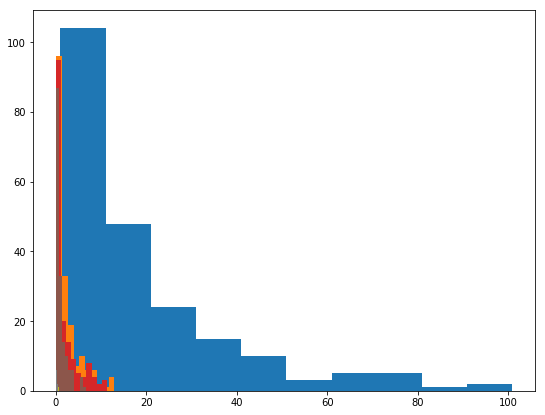

In [43]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,7))
plt.hist(drug_hit_array)
for sup_ in louv.cluster_super.unique():
    counts_normalized = np.ones_like(drug_hit_array)
    counts_normalized = np.maximum(drug_hit_array, counts_normalized)
    plt.hist(list(filter(lambda x: x > 0 ,drug_super_hit_dict_array[sup_]*np.array([drug_super_hit_normalizer[sup_][d] for d in drug_set])/counts_normalized)))
#plt.xlim([-1,120])

In [44]:
drug_super_hit_dict_array[sup_]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [45]:
np.max(drug_hit_array)

101

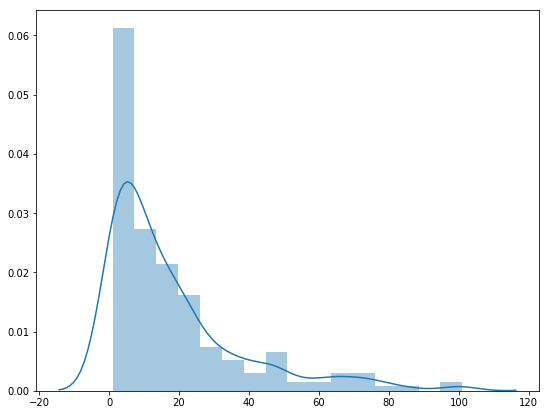

In [46]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,7))
sns.distplot(drug_hit_array)
plt.show()

([array([38.,  9.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([139.,  42.,  19.,   3.,   1.,   0.,   0.,   0.,   0.,   0.]),
  array([231.,  78.,  34.,   9.,   6.,   4.,   1.,   2.,   0.,   0.]),
  array([314., 107.,  49.,  18.,  16.,  10.,   5.,   4.,   5.,   1.]),
  array([395., 151.,  67.,  30.,  25.,  18.,   9.,   5.,   7.,   5.]),
  array([396., 151.,  67.,  30.,  25.,  18.,   9.,   5.,   7.,   5.]),
  array([480., 175.,  72.,  34.,  26.,  19.,   9.,   5.,   7.,   5.]),
  array([484., 175.,  72.,  34.,  26.,  19.,   9.,   5.,   7.,   5.])],
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <a list of 8 Lists of Patches objects>)

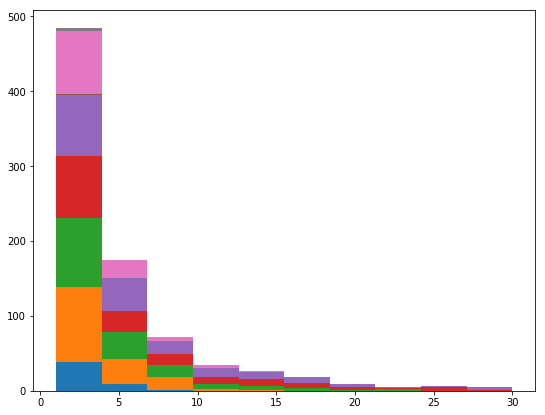

In [47]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,7))
plt.hist([list(filter(lambda x: x >0, drug_super_hit_dict_array[sup_])) for sup_ in set(louv.cluster_super.unique())], stacked=True)
#plt.semilogy()

In [48]:
drug_cross_super = pd.DataFrame([drug_super_hit_dict_array[sup_] for sup_ in set(louv.cluster_super.unique())])

In [49]:
louv['num_drugs'] = louv.Drug.apply(lambda x: len(x) if x is not np.nan else 0)
louv.head()

,names,cluster_super,cluster_sub,Drug,understudied,num_drugs
0,PAK1,5,3,NaN,False,0
1,ERBB2,5,18,NaN,False,0
2,MST1R,5,18,"[Golvatinib, Crizotinib, Foretinib, MK-2461, O...",False,16
3,YES1,5,18,"[TG-100572, Dasatinib, TAK-901, Ibrutinib, Dan...",False,31
4,TYRO3,5,18,NaN,False,0


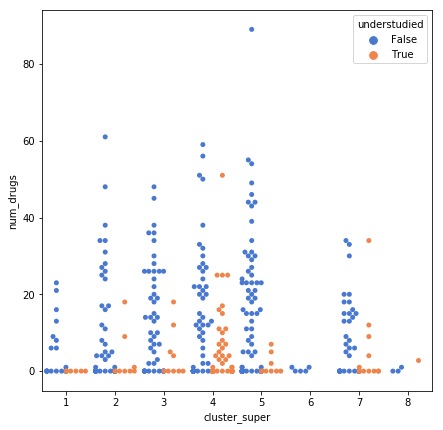

In [50]:
plt.figure(figsize=(7,7))
ax = sns.swarmplot(x='cluster_super', y="num_drugs", hue="understudied", data=louv, palette="muted", dodge=True)

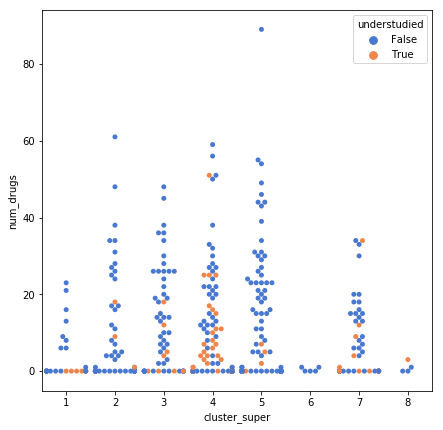

In [51]:
plt.figure(figsize=(7,7))
ax = sns.swarmplot(x='cluster_super', y="num_drugs", hue="understudied", data=louv, palette="muted")

In [52]:
drug_counter

Counter({'Milciclib': 75,
         'Cyc-116': 85,
         'MK-2461': 6,
         'MGCD-265': 18,
         'XL-228': 67,
         'Golvatinib': 32,
         'PF-03814735': 72,
         'Rebastinib': 57,
         'Fostamatinib': 17,
         'Foretinib': 38,
         'Crizotinib': 25,
         'Barasertib_HQPA': 11,
         'Gilteritinib': 55,
         'MK-8033': 2,
         'Barasertib': 11,
         'OTS-167': 99,
         'Sunitinib': 60,
         'Tesevatinib': 31,
         'BI-847325': 45,
         'TG-100801': 12,
         'CP-547632': 28,
         'Ibrutinib': 22,
         'ENMD-2076': 20,
         'AEE-788': 23,
         'PF-3758309': 73,
         'BMS-690514': 47,
         'ASP-3026': 36,
         'Dovitinib': 49,
         'Varlitinib': 4,
         'Dasatinib': 65,
         'TAK-901': 67,
         'AZD-7762': 61,
         'AV-412': 7,
         'Ponatinib': 45,
         'TAK-593': 9,
         'PF-477736': 49,
         'AT-9283': 101,
         'AEW-541': 22,
         'TG-100572'

In [53]:
selectivity_catter = lambda x: 0 if drug_counter[x] < 40 else 1 if drug_counter[x] < 60 else 2 if drug_counter[x] < 80 else 3

In [54]:
drug_data.head()

,Target,Drug,At,CATDS
0,AURKA,MK-5108,0.120921,0.657165
1,CHEK1,PF-477736,0.243725,0.733257
2,FLT3,Dovitinib,0.265240,0.860803
4,MET,Capmatinib,0.337514,1.000000
5,MAPKAPK2,VX-702,0.342705,0.743594


In [158]:
super_mapper = louv.set_index('names')['cluster_super'].to_dict()
sub_mapper = louv.set_index('names')['cluster_sub'].to_dict()
drug_data['cluster_super'] = drug_data.Target.apply(lambda x: super_mapper[x])
drug_data['cluster_sub'] = drug_data.Target.apply(lambda x: sub_mapper[x])
drug_data['understudied'] = drug_data.Target.isin(understudied.symbol)
drug_data['selectivity_score'] = drug_data.Drug.apply(selectivity_catter)

super_drug_num_hit = drug_data.groupby(['cluster_super', 'Drug'])['Target'].agg(len).to_dict()
super_drug_num_hit = {x:{y[1]:z for y, z in super_drug_num_hit.items() if y[0]==x} for x in set(louv.cluster_super.unique())}

sub_drug_num_hit = drug_data.groupby(['cluster_sub', 'Drug'])['Target'].agg(len).to_dict()
sub_drug_num_hit = {x:{y[1]:z for y, z in sub_drug_num_hit.items() if y[0]==x} for x in set(louv.cluster_sub.unique())}


In [159]:
drug_data['num_members_hit'] = [super_drug_num_hit[x][y] for x,y in zip(drug_data.cluster_super, drug_data.Drug)]
drug_data['sub_members_hit'] = [sub_drug_num_hit[x][y] for x,y in zip(drug_data.cluster_sub, drug_data.Drug)]

In [58]:
np.random.rand()-.5

0.29836550324106137

In [160]:
drug_data['num_members_hit'] = drug_data['num_members_hit'].apply(lambda x: x + np.random.rand()-.5)
drug_data['sub_members_hit'] = drug_data['sub_members_hit'].apply(lambda x: x + np.random.rand()-.5)

In [161]:
drug_data.head()

,Target,Drug,At,CATDS,cluster_super,understudied,selectivity_score,num_members_hit,cluster_sub,sub_members_hit
0,AURKA,MK-5108,0.120921,0.657165,4,False,0,5.999514,6,3.587799
1,CHEK1,PF-477736,0.243725,0.733257,4,False,1,14.222958,6,5.761918
2,FLT3,Dovitinib,0.265240,0.860803,2,False,1,6.304940,9,2.613650
4,MET,Capmatinib,0.337514,1.000000,5,False,0,1.162272,18,0.627484
5,MAPKAPK2,VX-702,0.342705,0.743594,3,False,0,3.310228,11,3.231238


<IPython.core.display.Javascript object>


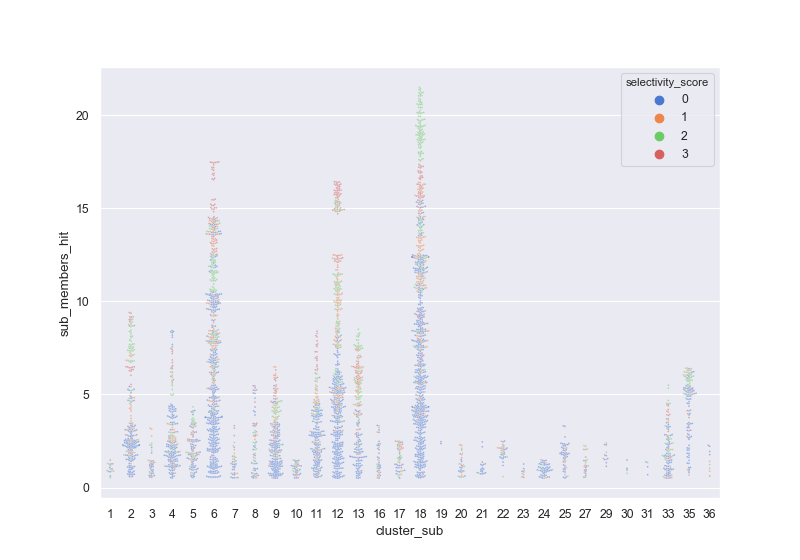

In [163]:
plt.figure(figsize=(10,7))
ax = sns.swarmplot(x='cluster_sub', y='sub_members_hit', hue="selectivity_score", data=drug_data, palette="muted", size=1.5, orient='v', alpha = .5)

<IPython.core.display.Javascript object>


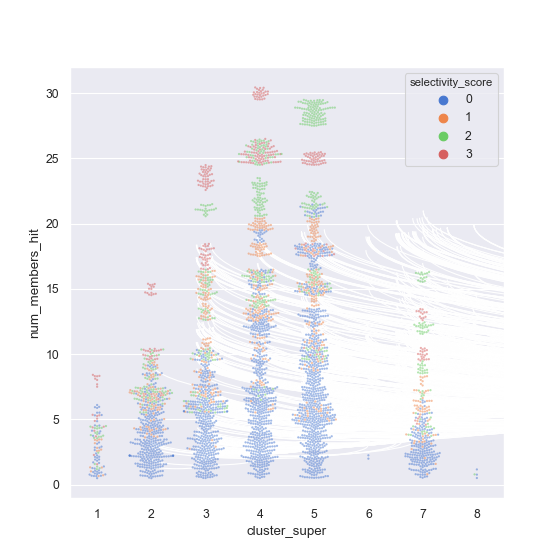

In [164]:
plt.figure(figsize=(7,7))
ax = sns.swarmplot(x='cluster_super', y='num_members_hit', hue="selectivity_score", data=drug_data, palette="muted", size=2, orient='v', alpha = .5)

<IPython.core.display.Javascript object>


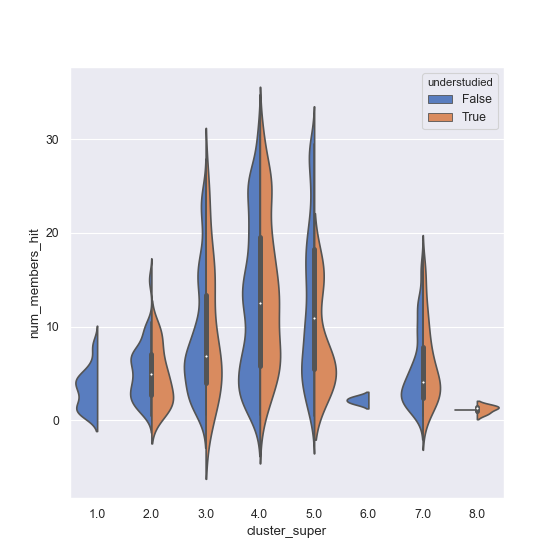

In [127]:
plt.figure(figsize=(7,7))
ax = sns.violinplot(x='cluster_super', y='num_members_hit', hue="understudied", data=drug_data, palette="muted", size=2, orient='v', alpha = .5, split=True)

In [139]:
drug_data.head()

,Target,Drug,At,CATDS,cluster_super,understudied,selectivity_score,num_members_hit
0,AURKA,MK-5108,0.120921,0.657165,4.0,False,0,6.373144
1,CHEK1,PF-477736,0.243725,0.733257,4.0,False,1,13.797111
2,FLT3,Dovitinib,0.265240,0.860803,2.0,False,1,6.190081
4,MET,Capmatinib,0.337514,1.000000,5.0,False,0,0.735037
5,MAPKAPK2,VX-702,0.342705,0.743594,3.0,False,0,2.841009


In [142]:
drug_data[drug_data['understudied']==False]

,Target,Drug,At,CATDS,cluster_super,understudied,selectivity_score,num_members_hit
0,AURKA,MK-5108,0.120921,0.657165,4.0,False,0,6.373144
1,CHEK1,PF-477736,0.243725,0.733257,4.0,False,1,13.797111
2,FLT3,Dovitinib,0.265240,0.860803,2.0,False,1,6.190081
4,MET,Capmatinib,0.337514,1.000000,5.0,False,0,0.735037
5,MAPKAPK2,VX-702,0.342705,0.743594,3.0,False,0,2.841009
6,GAK,BMS-690514,0.349505,0.549619,4.0,False,1,7.671708
7,EPHA5,TG-100572,0.359391,0.203639,5.0,False,0,15.203462
8,CLK2,GSK-1059615,0.380274,0.437914,4.0,False,0,8.554528
9,PTK2,Defactinib,0.465398,0.415668,5.0,False,0,3.601251
10,EPHB6,TG-100572,0.570466,0.119045,5.0,False,0,14.543442


<IPython.core.display.Javascript object>


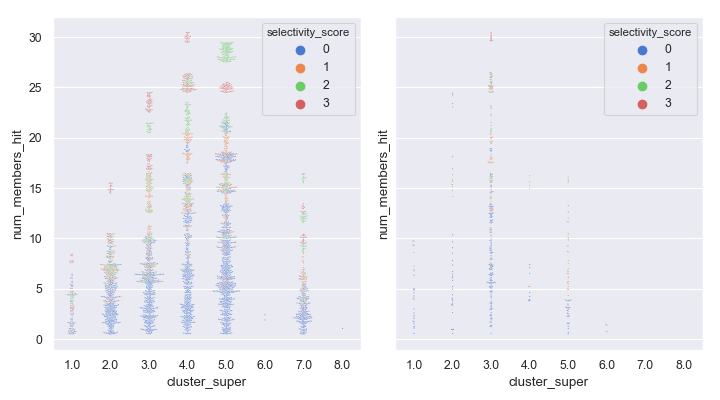

In [144]:
#sns.set(rc={'figure.figsize':(14,10)})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5), sharey=True, sharex=True)


___ = sns.swarmplot(x='cluster_super', y='num_members_hit', hue="selectivity_score", data=drug_data[drug_data['understudied']==True], palette="muted", size=1, orient='v', alpha = .7, ax = axes[1])
__ = sns.swarmplot(x='cluster_super', y='num_members_hit', hue="selectivity_score", data=drug_data[drug_data['understudied']==False], palette="muted", size=1, orient='v', alpha = .7, ax = axes[0])
#g = sns.catplot(x="cluster_super", y="num_members_hit", kind='swarm', hue="selectivity_score", height=5, col="understudied", data=drug_data, palette="muted", alpha = 0.5, sizes=[2])
#ax = sns.swarmplot(x='cluster_super', y='num_members_hit', hue="selectivity_score", data=drug_data, palette="muted", size=2, orient='v', alpha = .5)

plt.tight_layout()
plt.show()

### Balloon Plot of Supercluster x Family

In [62]:
kmast = pd.read_excel('../../data/KINASESmasterlist_w_Aliases.xlsx')
kmast.head()

,Uniprot Protein,MS Gene,RNAseq Gene,RNAseq Accession,Family,Mouse Uniprot Protein,Mouse RNAseq gene,Mouse RNAseq Accession,Kinome Render Tree Name,Aliases (Conservative),...,Aliases,description,other_designations,Entrez_Symbol,Old_Name,Entrez_Synonyms,Entrez_other_designations,Unnamed: 18,Gene Symbol,Gene Symbol and Synonyms
0,AAK1,AAK1,AAK1,22848.0,Other,Aak1,Aak1,269774,AAK1,"AAK1,",...,NaN,AP2 associated kinase 1,adaptor-associated kinase 1,AAK1,AAK1,KIAA1048|MGC138170,adaptor-associated kinase 1,NaN,AAK1,AAK1
1,AAPK1,PRKAA1,PRKAA1,5562.0,CAMK,Aapk1,Prkaa1,105787,AMPK[alpha]1,"PRKAA1, AMPKa1",...,"AMPK, AMPKa1","protein kinase, AMP-activated, alpha 1 catalyt...","5'-AMP-activated protein kinase, catalytic alp...",PRKAA1,AMPKa1,AMPK|AMPKa1|MGC33776|MGC57364,"5'-AMP-activated protein kinase, catalytic alp...",NaN,PRKAA1,"AMPK, PRKAA1, AMPKa1"
2,AAPK2,PRKAA2,PRKAA2,5563.0,CAMK,Aapk2,Prkaa2,108079,AMPK[alpha]2,"PRKAA2, AMPK2, AMPKa2, PRKAA",...,"AMPK, AMPK2, AMPKa2, PRKAA","protein kinase, AMP-activated, alpha 2 catalyt...","5'-AMP-activated protein kinase, catalytic alp...",PRKAA2,AMPKa2,AMPK|AMPK2|PRKAA,"5'-AMP-activated protein kinase, catalytic alp...",NaN,PRKAA2,"AMPK2, AMPK, PRKAA, AMPKa2, PRKAA2"
3,ABL1,ABL1,ABL1,25.0,TK,Abl1,Abl1,11350,Abl,"ABL1,ABL, JTK7, bcr/abl, c-ABL, c-ABL1, v-abl",...,"ABL, JTK7, bcr/abl, c-ABL, c-ABL1, p150, v-abl","ABL proto-oncogene 1, non-receptor tyrosine ki...",Abelson tyrosine-protein kinase 1|bcr/c-abl on...,ABL1,ABL,ABL|JTK7|c-ABL|p150|v-abl,Abelson murine leukemia viral (v-abl) oncogene...,NaN,ABL1,"c-ABL1, p150, ABL, JTK7, v-abl, bcr/abl, c-ABL..."
4,ABL2,ABL2,ABL2,27.0,TK,Abl2,Abl2,11352,Arg,"ABL2,ABLL, ARG",...,"ABLL, ARG","ABL proto-oncogene 2, non-receptor tyrosine ki...","abelson-related gene protein|c-abl oncogene 2,...",ABL2,ARG,ABLL|ARG,Abelson murine leukemia viral (v-abl) oncogene...,NaN,ABL2,"ABL2, ABLL, ARG"


In [63]:
kmast['HGNC Gene'] = kmast['MS Gene'].apply(lambda x: hgnc_mapper[x] if x in hgnc_mapper.keys() else np.nan)
kmast = kmast[~kmast['HGNC Gene'].isna()]
family_dict = kmast.set_index('MS Gene')['Family'].to_dict()

In [64]:
set(family_dict.values())

{'AGC',
 'Atypical',
 'CAMK',
 'CK1',
 'CMGC',
 'Metabolic',
 'NEK',
 'Other',
 'RGC',
 'STE',
 'TK',
 'TKL'}

In [65]:
family_dict['MAP3K20'] = 'STE'
family_dict['GRK2'] = 'AGC'
family_dict['STK26'] = 'STE'
family_dict['MAP3K21'] = 'STE'
family_dict['COQ8A'] = 'Other'
family_dict['HASPIN'] = 'Other'
family_dict['GRK3'] = 'AGC'
family_dict['COQ8B'] = 'Other'
family_dict['PAK5'] = 'STE'

In [66]:
len([family_dict[x] for x in set(louv.names) if x in family_dict.keys()])

473

In [67]:
louv['family'] = louv.names.apply(lambda x: family_dict[x])

In [68]:
louv

,names,cluster_super,cluster_sub,Drug,understudied,num_drugs,family
0,PAK1,5,3,NaN,False,0,STE
1,ERBB2,5,18,NaN,False,0,TK
2,MST1R,5,18,"[Golvatinib, Crizotinib, Foretinib, MK-2461, O...",False,16,TK
3,YES1,5,18,"[TG-100572, Dasatinib, TAK-901, Ibrutinib, Dan...",False,31,TK
4,TYRO3,5,18,NaN,False,0,TK
5,LYN,2,4,"[Dasatinib, Ponatinib, Bosutinib, BI-847325, F...",False,34,TK
6,KIT,5,18,[Dasatinib],False,1,TK
7,PRKCA,5,5,"[Sotrastaurin, Ruboxistaurin, UCN-01, Decernot...",False,26,AGC
8,SRC,5,18,"[TG-100572, Dasatinib, Foretinib, Danusertib, ...",False,23,TK
9,MATK,5,18,NaN,False,0,TK


In [69]:
family_counts = Counter(list(louv.family))
super_family_counts = louv.groupby('cluster_super')['family'].agg(list).apply(lambda x: Counter(x))
super_family_counts

cluster_super
1    {'TKL': 12, 'STE': 3, 'CAMK': 4, 'Other': 6, '...
2    {'TK': 16, 'AGC': 16, 'Atypical': 11, 'Other':...
3    {'STE': 25, 'CAMK': 5, 'CMGC': 12, 'TKL': 5, '...
4    {'Atypical': 13, 'CAMK': 29, 'CMGC': 38, 'Meta...
5    {'STE': 4, 'TK': 62, 'AGC': 12, 'CAMK': 10, 'M...
6                                     {'Metabolic': 5}
7    {'CMGC': 4, 'STE': 2, 'TKL': 5, 'AGC': 14, 'TK...
8                           {'Metabolic': 3, 'TKL': 1}
Name: family, dtype: object

In [71]:
## normalize super_family_counts by size of family_counts
family_set = list(set(family_dict.values()))
for sup_ in super_family_counts.keys():
    # replace the counter with a normalized size dict
    normalized_size_dict = {}
    for fam in family_set:
        normalized_size_dict[fam] = super_family_counts[sup_][fam] / family_counts[fam]
        
    super_family_counts[sup_] = normalized_size_dict

In [72]:
super_family_cross_x, super_family_cross_size = zip(*[(x,super_family_counts[x][y]*np.log(super_family_counts[x][y]+1)*1000) for x in super_family_counts.keys() for y in family_set])

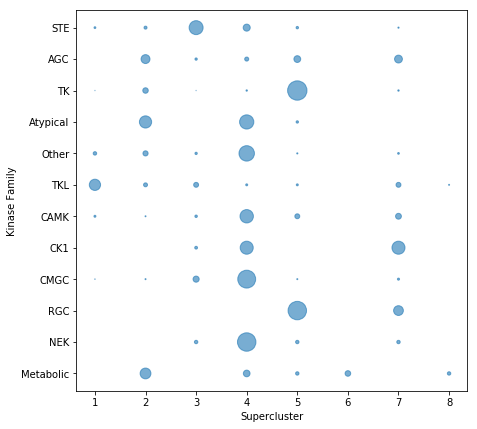

In [73]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
plt.scatter(x=super_family_cross_x, y=family_set*len(super_family_counts.keys()), s=super_family_cross_size, alpha=.6)
plt.xlabel('Supercluster')
plt.ylabel('Kinase Family')
#ax.set_yscale("log", basey=2)#, nonposy='clip')
#plt.ylim([-2,4])
plt.show()

### broot plot

<IPython.core.display.Javascript object>


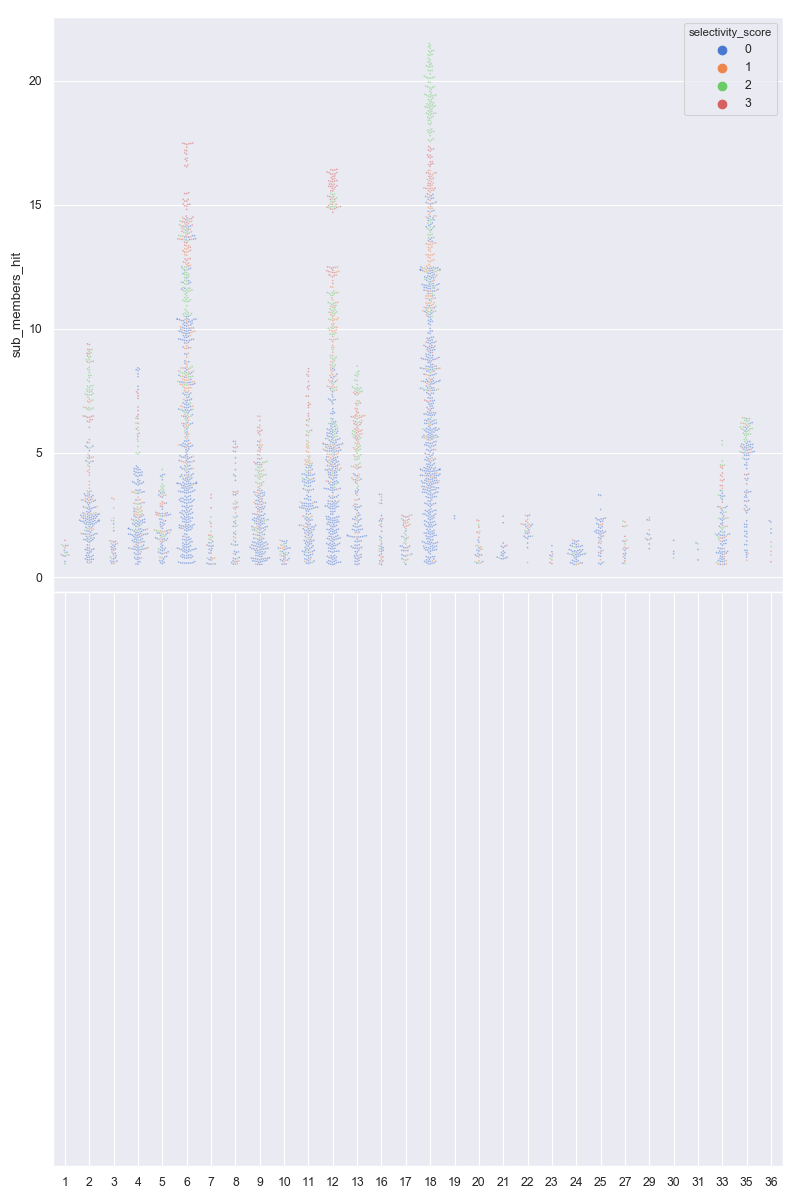

In [174]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,15), sharex=True)
sns.swarmplot(x='cluster_sub', y='sub_members_hit', hue="selectivity_score", data=drug_data, palette="muted", size=1.5, orient='v', alpha = .5, ax = axes[0])
axes[1].set_ylim([0,-10])
axes[1].yaxis.set_ticks([])
plt.tight_layout()
fig.subplots_adjust(hspace=0)




In [184]:
root_xy_dict = {}
biggest_clust = max(louv.groupby('cluster_sub')['names'].agg(len).to_dict().values())

for sub_ in set(louv.cluster_sub.unique()):
    sub_louv = copy(louv[louv.cluster_sub == sub_])
    sub_num_pres = len(sub_louv)
    
    nodes_to_add_x = [sub_-sub_num_pres/2.0/biggest_clust + i*1.0/biggest_clust for i in range(sub_num_pres)]
    nodes_to_add_y = [-.2 for x in nodes_to_add_x]
    
    for k,x,y in zip(sub_louv.names, nodes_to_add_x, nodes_to_add_y):
        root_xy_dict[k] = (x,y)

In [191]:
network = pd.read_csv('../../data/KIN_edges_no_weights.txt', sep='\t', header=None)
network.columns = ['Node1','Node2']
network['Node1'] = network['Node1'].apply(lambda x: hgnc_mapper[x])
network['Node2'] = network['Node2'].apply(lambda x: hgnc_mapper[x])
network.head()

,Node1,Node2
0,PAK1,ERBB2
1,MST1R,YES1
2,TYRO3,YES1
3,LYN,KIT
4,PRKCA,KIT


In [208]:
drug_data.cluster_sub

0        6
1        6
2        9
4       18
5       11
6        6
7       18
8        6
9       18
10      18
12      20
13      18
14       9
15      35
16      12
17      18
18      18
19       6
20       6
21      18
22      18
23      18
25      35
26      18
27      18
28      12
29      18
31      18
32       8
33      13
        ..
4351     6
4352    35
4353    12
4354     6
4355    13
4356    12
4358    33
4359     9
4360    11
4361    29
4362    18
4363    12
4364     4
4365    25
4367    13
4368    35
4369    18
4370    25
4371     6
4372     2
4373    33
4374    12
4375     6
4377     6
4378    12
4379    12
4380     5
4382    24
4384     9
4385     9
Name: cluster_sub, Length: 3920, dtype: int64

In [228]:
max([y[1] for x,y in root_xy_dict.items()])

-0.2

In [215]:
min([root_xy_dict[x][0] for x in network.Node2])

0.9886363636363636

<IPython.core.display.Javascript object>


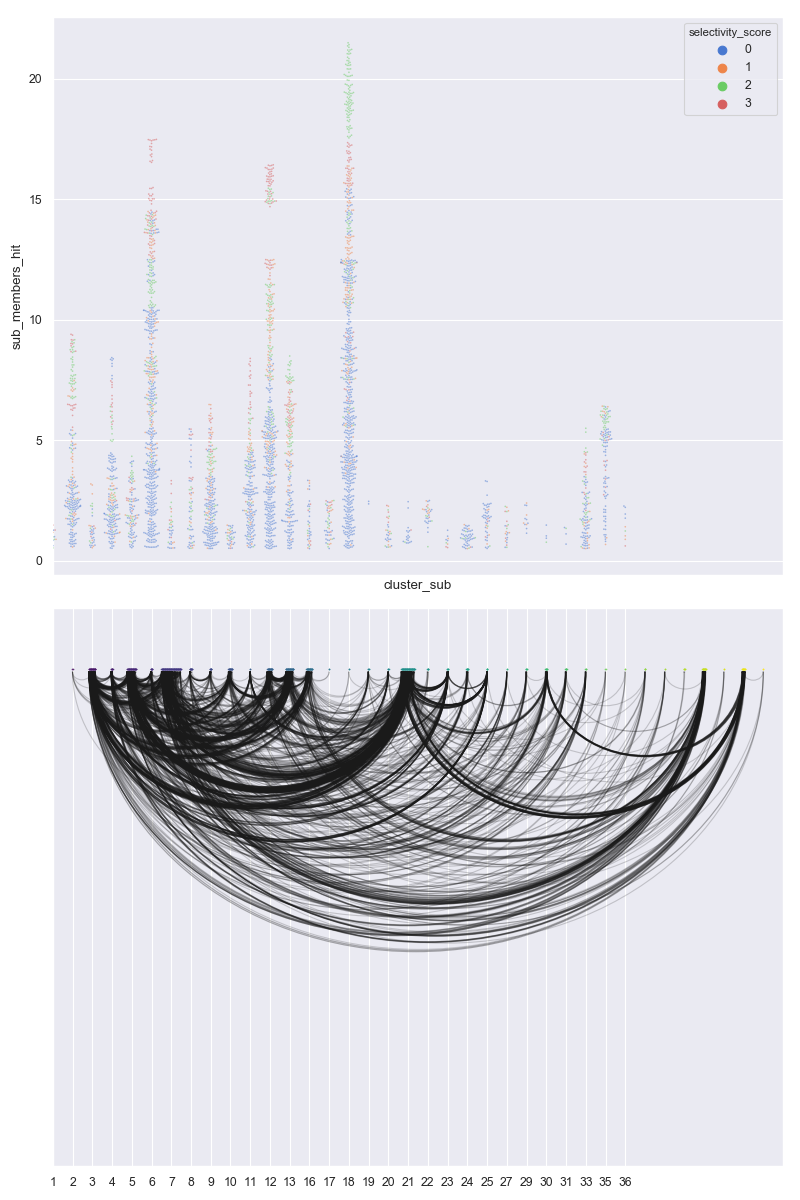

(0, 37)

In [248]:
from matplotlib.patches import Arc
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,15), sharex=True)
g = sns.swarmplot(x='cluster_sub', y='sub_members_hit', hue="selectivity_score", data=drug_data, palette="muted", size=1.5, orient='v', alpha = .5, ax=axes[0])
g.set(xlim=(0,37))

axes[1].set_ylim([-10,1])
axes[1].yaxis.set_ticks([])
plt.tight_layout()
#fig.subplots_adjust(hspace=0)

# add nodes for each of the clusters (un-centered)
for sub_ in set(louv.cluster_sub.unique()):
    sub_louv = copy(louv[louv.cluster_sub == sub_])
    
    sub_nodes_x, sub_nodes_y = zip(*[root_xy_dict[k] for k in set(sub_louv.names)])
    #print(sub_nodes_x)
    
    axes[1].scatter(x=sub_nodes_x, y = sub_nodes_y, color=cm.viridis(sub_/36.0), s=.2)

for edge in zip(network.Node1, network.Node2):
    #print(edge)
    node1_x, node1_y = root_xy_dict[edge[0]]
    node2_x, node2_y = root_xy_dict[edge[1]]
    
    arc_center_x = (node1_x + node2_x)/2.0
    arc_center_y = (node1_y + node2_y -.1)/2.0
    
    arc_width = float(np.abs(node2_x - node1_x))
    #print('node1x: ', np.round(node1_x,2), '\tnode2x: ', np.round(node2_x,2), '\twidth: ',np.round(arc_width,2))
    arc_height = arc_width/3.0
    
    #print('center: ', (np.round(arc_center_x,2), np.round(arc_center_y,2)), '\twidth: ', np.round(arc_width,2), 'left: ', np.round(arc_center_x-arc_width,2), 'right: ', np.round(arc_center_x+arc_width,2))
    
    arc_offset_angle = 180.0
    
    arc_starting_angle, arc_ending_angle = (0.0,180.0)
    
    a = Arc(xy=(arc_center_x,arc_center_y),
            width=arc_width, height=arc_height,
            angle=arc_offset_angle,
            theta1=arc_starting_angle, theta2=arc_ending_angle,
            color='k', alpha = .2)
    #print(a)
    axes[1].add_patch(a)
    
    
    #break
        
plt.show()

#axes[0].set_xlim([0,37])
axes[1].set_xlim([0,37])


In [271]:
'ICK' in set(understudied.symbol)

True

In [290]:
len(set(louv.cluster_sub.unique()))

36

In [303]:
super_sub_dict = louv.groupby('cluster_super')['cluster_sub'].agg(set).to_dict()
super_sub_dict

{1: {7, 8, 26},
 2: {4, 9, 10, 20, 21},
 3: {11, 12},
 4: {1, 6, 13, 14, 15, 16, 17, 23, 24, 27, 28, 32, 34, 36},
 5: {3, 5, 18, 25, 29, 31, 35},
 6: {19},
 7: {2, 22, 33},
 8: {30}}

In [304]:
drug_data_ext = copy(drug_data)
sample_row = copy(drug_data.loc[0])
for sup_ in super_sub_dict.keys():
    for sub_ in super_sub_dict[sup_]:
        sample_row['Target'] = None
        sample_row['Drug'] = None
        sample_row['cluster_sub'] = sub_
        sample_row['cluster_super'] = sup_
        sample_row['num_members_hit'] = 0
        sample_row['sub_members_hit'] = 0
        
        drug_data_ext = drug_data_ext.append(sample_row)
        #sample_row

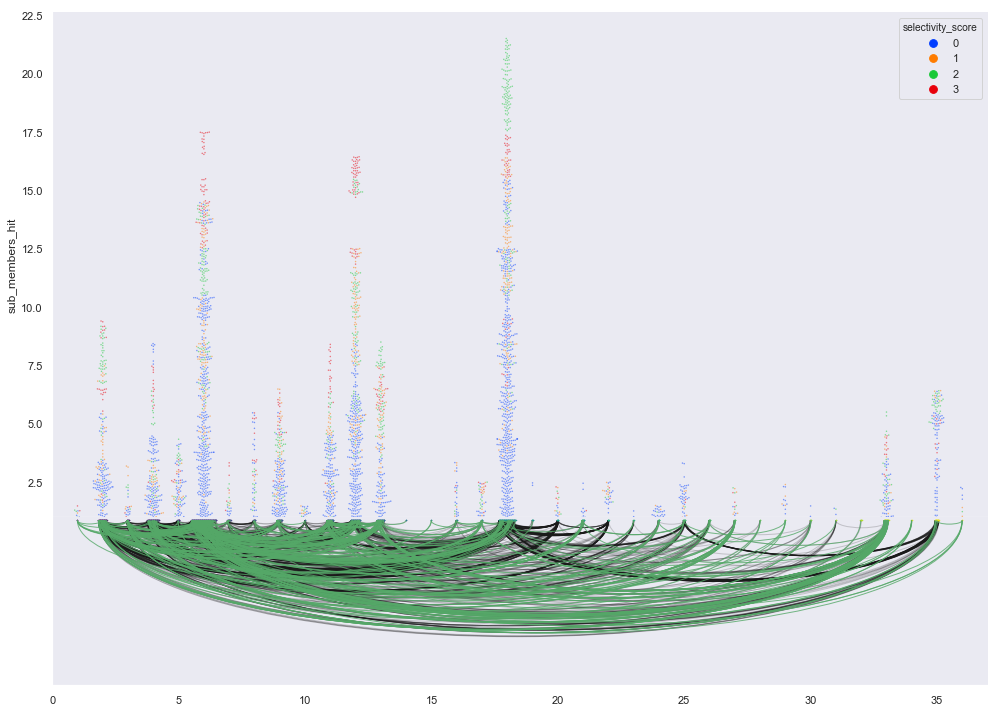

In [310]:
%matplotlib inline
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(14,10), gridspec_kw = {'height_ratios':[3, 1]})
g = sns.swarmplot(x='cluster_sub', y='sub_members_hit', hue="selectivity_score", data=drug_data_ext, palette="bright", size=1.5, orient='v', alpha = .5, ax=axes[0])
g.set(xlim=(-1,36))
g.set(ylim=(1,None))
g.grid(False)
sns.despine()
axes[1].set_ylim([-12,0])
axes[1].yaxis.set_ticks([])
axes[1].set_xlim([0,37])
axes[1].grid(False)
plt.tight_layout()
fig.subplots_adjust(hspace=0)

under = set(understudied.symbol)

# add nodes for each of the clusters (un-centered)
for sub_ in set(louv.cluster_sub.unique()):
    sub_louv = copy(louv[louv.cluster_sub == sub_])
    sub_nodes_x, sub_nodes_y = zip(*[root_xy_dict[k] for k in set(sub_louv.names)])
    #print(sub_nodes_x)
    
    axes[1].scatter(x=sub_nodes_x, y = sub_nodes_y, color=cm.viridis(sub_/36.0), s=.3)

for edge in zip(network.Node1, network.Node2):
    #print(edge)
    node1_x, node1_y = root_xy_dict[edge[0]]
    node2_x, node2_y = root_xy_dict[edge[1]]
    
    arc_center_x = (node1_x + node2_x)/2.0
    arc_center_y = (node1_y + node2_y -.1)/2.0
    
    arc_width = float(np.abs(node2_x - node1_x))
    #print('node1x: ', np.round(node1_x,2), '\tnode2x: ', np.round(node2_x,2), '\twidth: ',np.round(arc_width,2))
    arc_height = arc_width/2.0
    
    #print('center: ', (np.round(arc_center_x,2), np.round(arc_center_y,2)), '\twidth: ', np.round(arc_width,2), 'left: ', np.round(arc_center_x-arc_width,2), 'right: ', np.round(arc_center_x+arc_width,2))
    
    arc_offset_angle = 180.0
    
    arc_starting_angle, arc_ending_angle = (0.0,180.0)
    
    co = 'g' if edge[0] in under or edge[1] in under else 'k'
    al = .8 if edge[0] in under or edge[1] in under else .2
    zo = 1 if edge[0] in under or edge[1] in under else 0
    
    a = Arc(xy=(arc_center_x,arc_center_y),
            width=arc_width, height=arc_height,
            angle=arc_offset_angle,
            theta1=arc_starting_angle, theta2=arc_ending_angle,
            color=co, alpha = al, zorder=zo)
    
    #print(a)
    axes[1].add_patch(a)
    
    
    #break

plt.savefig('subcluster_sequoia.pdf', orientation='landscape')
plt.show()

#axes[0].set_xlim([0,5])
